In [166]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import random
from tensorflow.keras.optimizers import Adam
from pylab import rcParams
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style="darkgrid", palette='muted', font_scale=1.2)
whimsy_pallette = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(whimsy_pallette))
rcParams['figure.figsize'] = 12, 8

In [167]:
data_path = 'data/ecg.csv'
df = pd.read_csv(data_path, header=None)

You can see by scrolling to the last column that it contains the labels - 0 is an anomalous heartbeat, 1 is a normal heartbeat.

### Drop target from data; create target df with labels

In [168]:
raw_data = df.values

# The last element contains the labels
target = raw_data[:, -1]

# The other data points are the electrocadriogram data
features = raw_data[:, 0:-1]

### Train Test Split

In [169]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=21,
)

### Scale the input as tensor arrays

In [170]:
min_val = tf.reduce_min(x_train)
max_val = tf.reduce_max(x_train)

x_train = (x_train - min_val) / (max_val - min_val)
x_test = (x_test - min_val) / (max_val - min_val)

x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

### Separate the normal and anomalous ECGs

In [171]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

x_norm_train = x_train[y_train]
x_norm_test = x_test[y_test]

x_abnorm_train = x_train[~y_train]
x_abnorm_test = x_test[~y_test]

### Plot a normal ECG and abnormal ECG

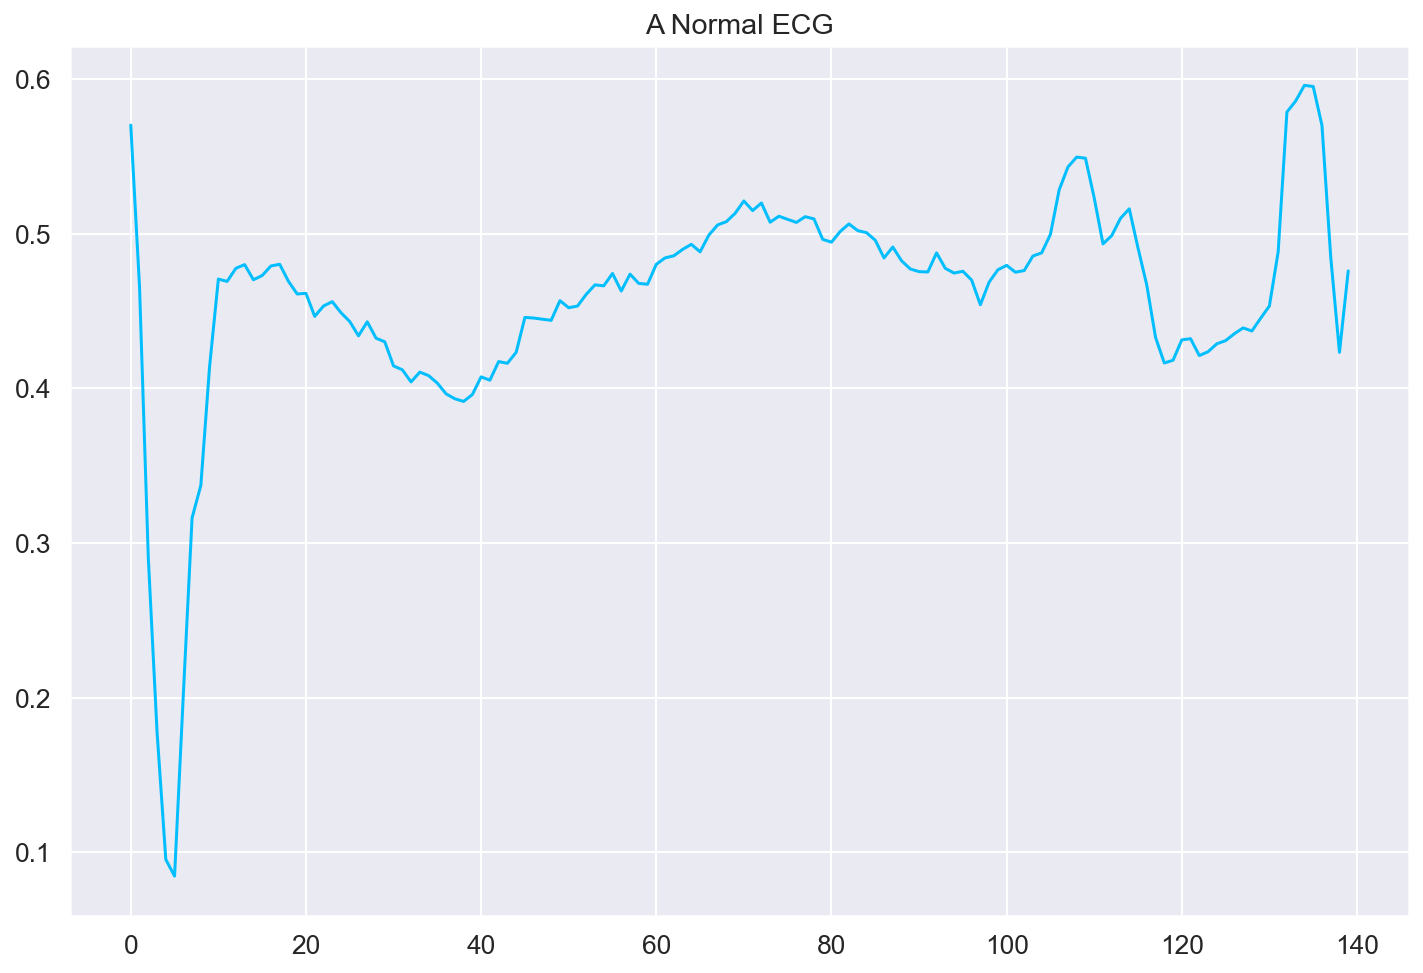

In [172]:
# 1st ECG in the normal set
plt.plot(np.arange(140), x_norm_train[0])
plt.title("A Normal ECG")
plt.savefig('images/normal_ecg.png', dpi=300, pad_inches=0.1,)
plt.show()

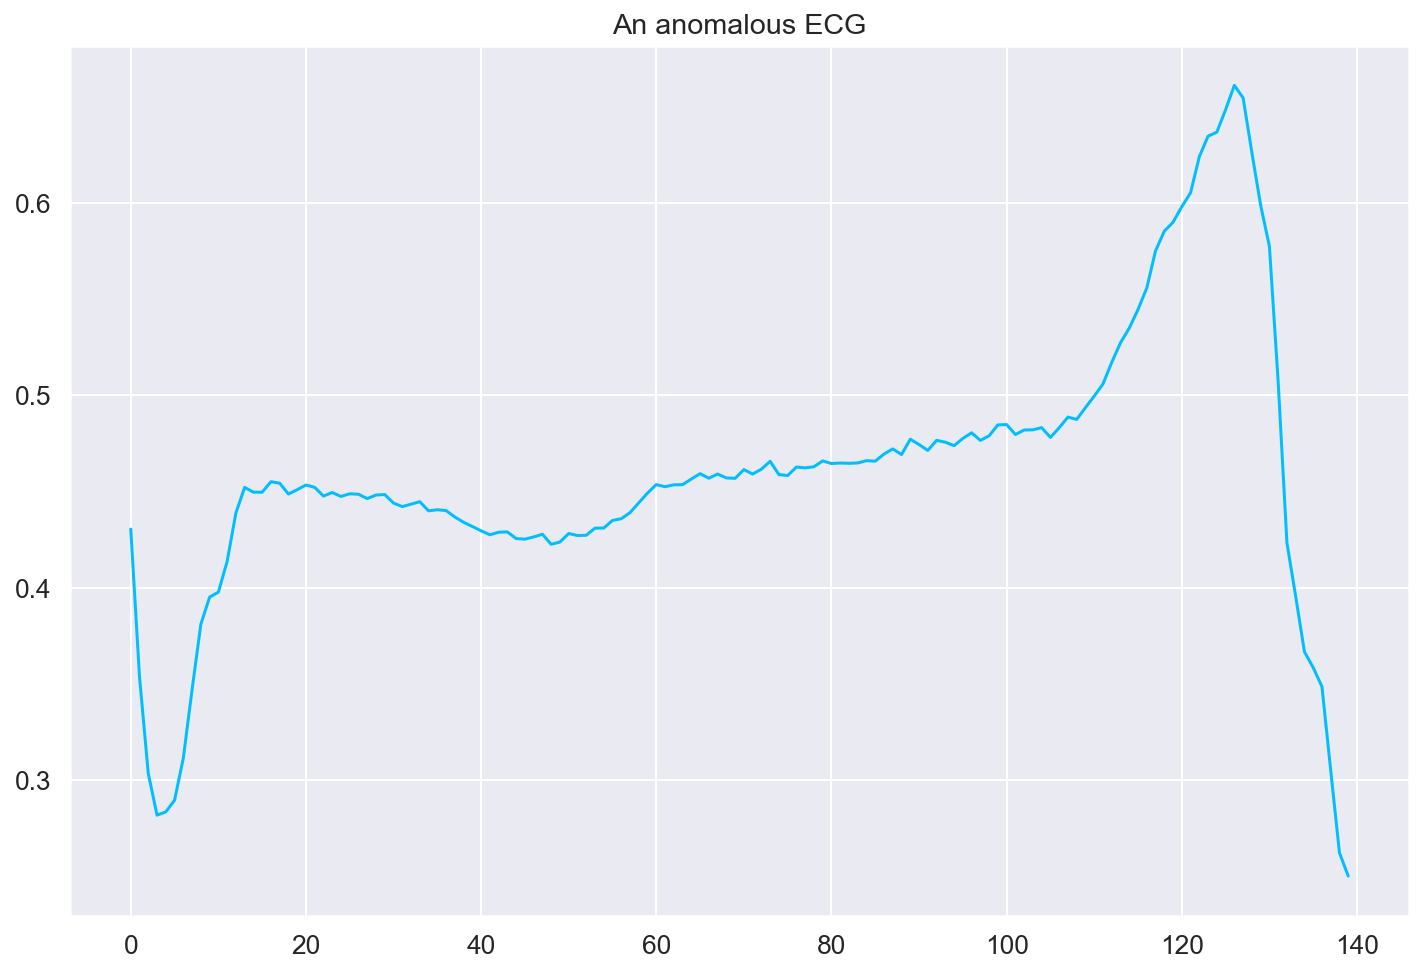

In [173]:
# 1st ECG in the abnormal set
plt.plot(np.arange(140), x_abnorm_train[0])
plt.title("An anomalous ECG")
plt.savefig('images/anomalous_ecg.png', dpi=300, pad_inches=0.1,)
plt.show()

In [174]:
def plot_ecg(title, df, save_file_name):
    
    encoded_imgs = encoder(df).numpy()
    decoded_imgs = decoder(encoded_imgs).numpy()
    
    a = 5  # number of rows
    b = 2  # number of columns
    c = 1  # initialize plot counter
    
    fig = plt.figure(figsize=(22,30))
    fig.tight_layout()
    
    for i in range(0,10):
        x = np.random.randint(low=0, high=(len(df)-1))
        plt.subplot(a, b, c)
        plt.plot(df[x],'darkblue',)
        plt.plot(decoded_imgs[x],'crimson')
        plt.fill_between(np.arange(140), decoded_imgs[x], df[x], color='#F9E79F' )
        plt.title(f'ECG #{x+1}')
        plt.legend(labels=["Input", "Reconstruction", "Error"])
        c = c + 1
    
    plt.suptitle(title, 
             x=(50-(len(title)/4))/100, y=.92, 
             horizontalalignment='left', 
             verticalalignment='bottom', 
             fontweight ="bold")
    plt.savefig(save_file_name, dpi=300, pad_inches=0.1,)
    plt.show()

In [175]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.mae(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.mae(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

def print_stats(predictions, labels):
  print(f"Accuracy = {accuracy_score(labels, preds)}")
  print(f"Precision = {precision_score(labels, preds)}")
  print(f"Recall = {recall_score(labels, preds)}")

### Model

In [176]:
encoder = Sequential([
      Dense(28, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(60, activation='relu'),
      Dropout(0.1),
      Dense(8, activation='relu')
    ])
decoder = Sequential([
      Dense(56, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(60, activation='relu'),
      Dropout(0.1),
      Dense(140, activation='sigmoid')
    ])

In [177]:
best_model = keras.models.Sequential([encoder, decoder])
best_model.compile(loss='mae', optimizer=Adam(learning_rate = 0.001))

In [178]:
history = best_model.fit(
    x_norm_train,
    x_norm_train,
    epochs=100,
    batch_size=512,
    validation_data=(x_test, x_test)
)

Epoch 1/100
5/5 [==============================] - 1s 30ms/step - loss: 0.0572 - val_loss: 0.0517
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0531 - val_loss: 0.0484
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0482 - val_loss: 0.0448
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0436 - val_loss: 0.0422
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0398 - val_loss: 0.0406
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0364 - val_loss: 0.0392
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0339 - val_loss: 0.0381
Epoch 8/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0319 - val_loss: 0.0372
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0301 - val_loss: 0.0365
Epoch 10/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0289 - val_loss: 0.0356
Epoch 11/100
5/5 [==========

In [179]:
best_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_32 (Sequential)  (None, 8)                 10192     
                                                                 
 sequential_33 (Sequential)  (None, 140)               12848     
                                                                 
Total params: 23,040
Trainable params: 23,040
Non-trainable params: 0
_________________________________________________________________


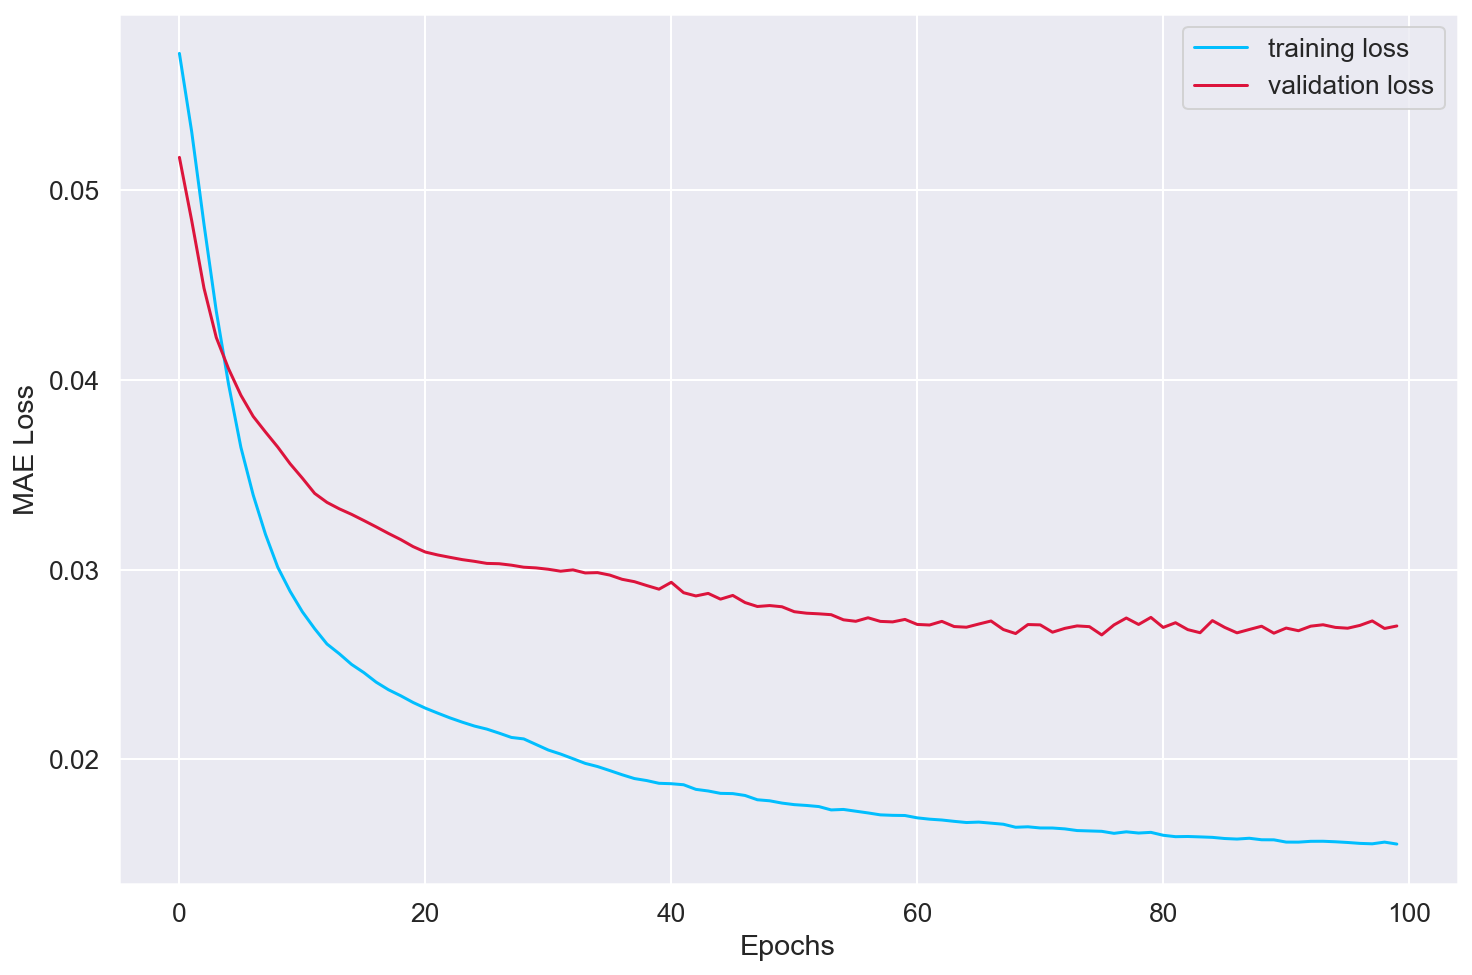

In [180]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],color='crimson')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

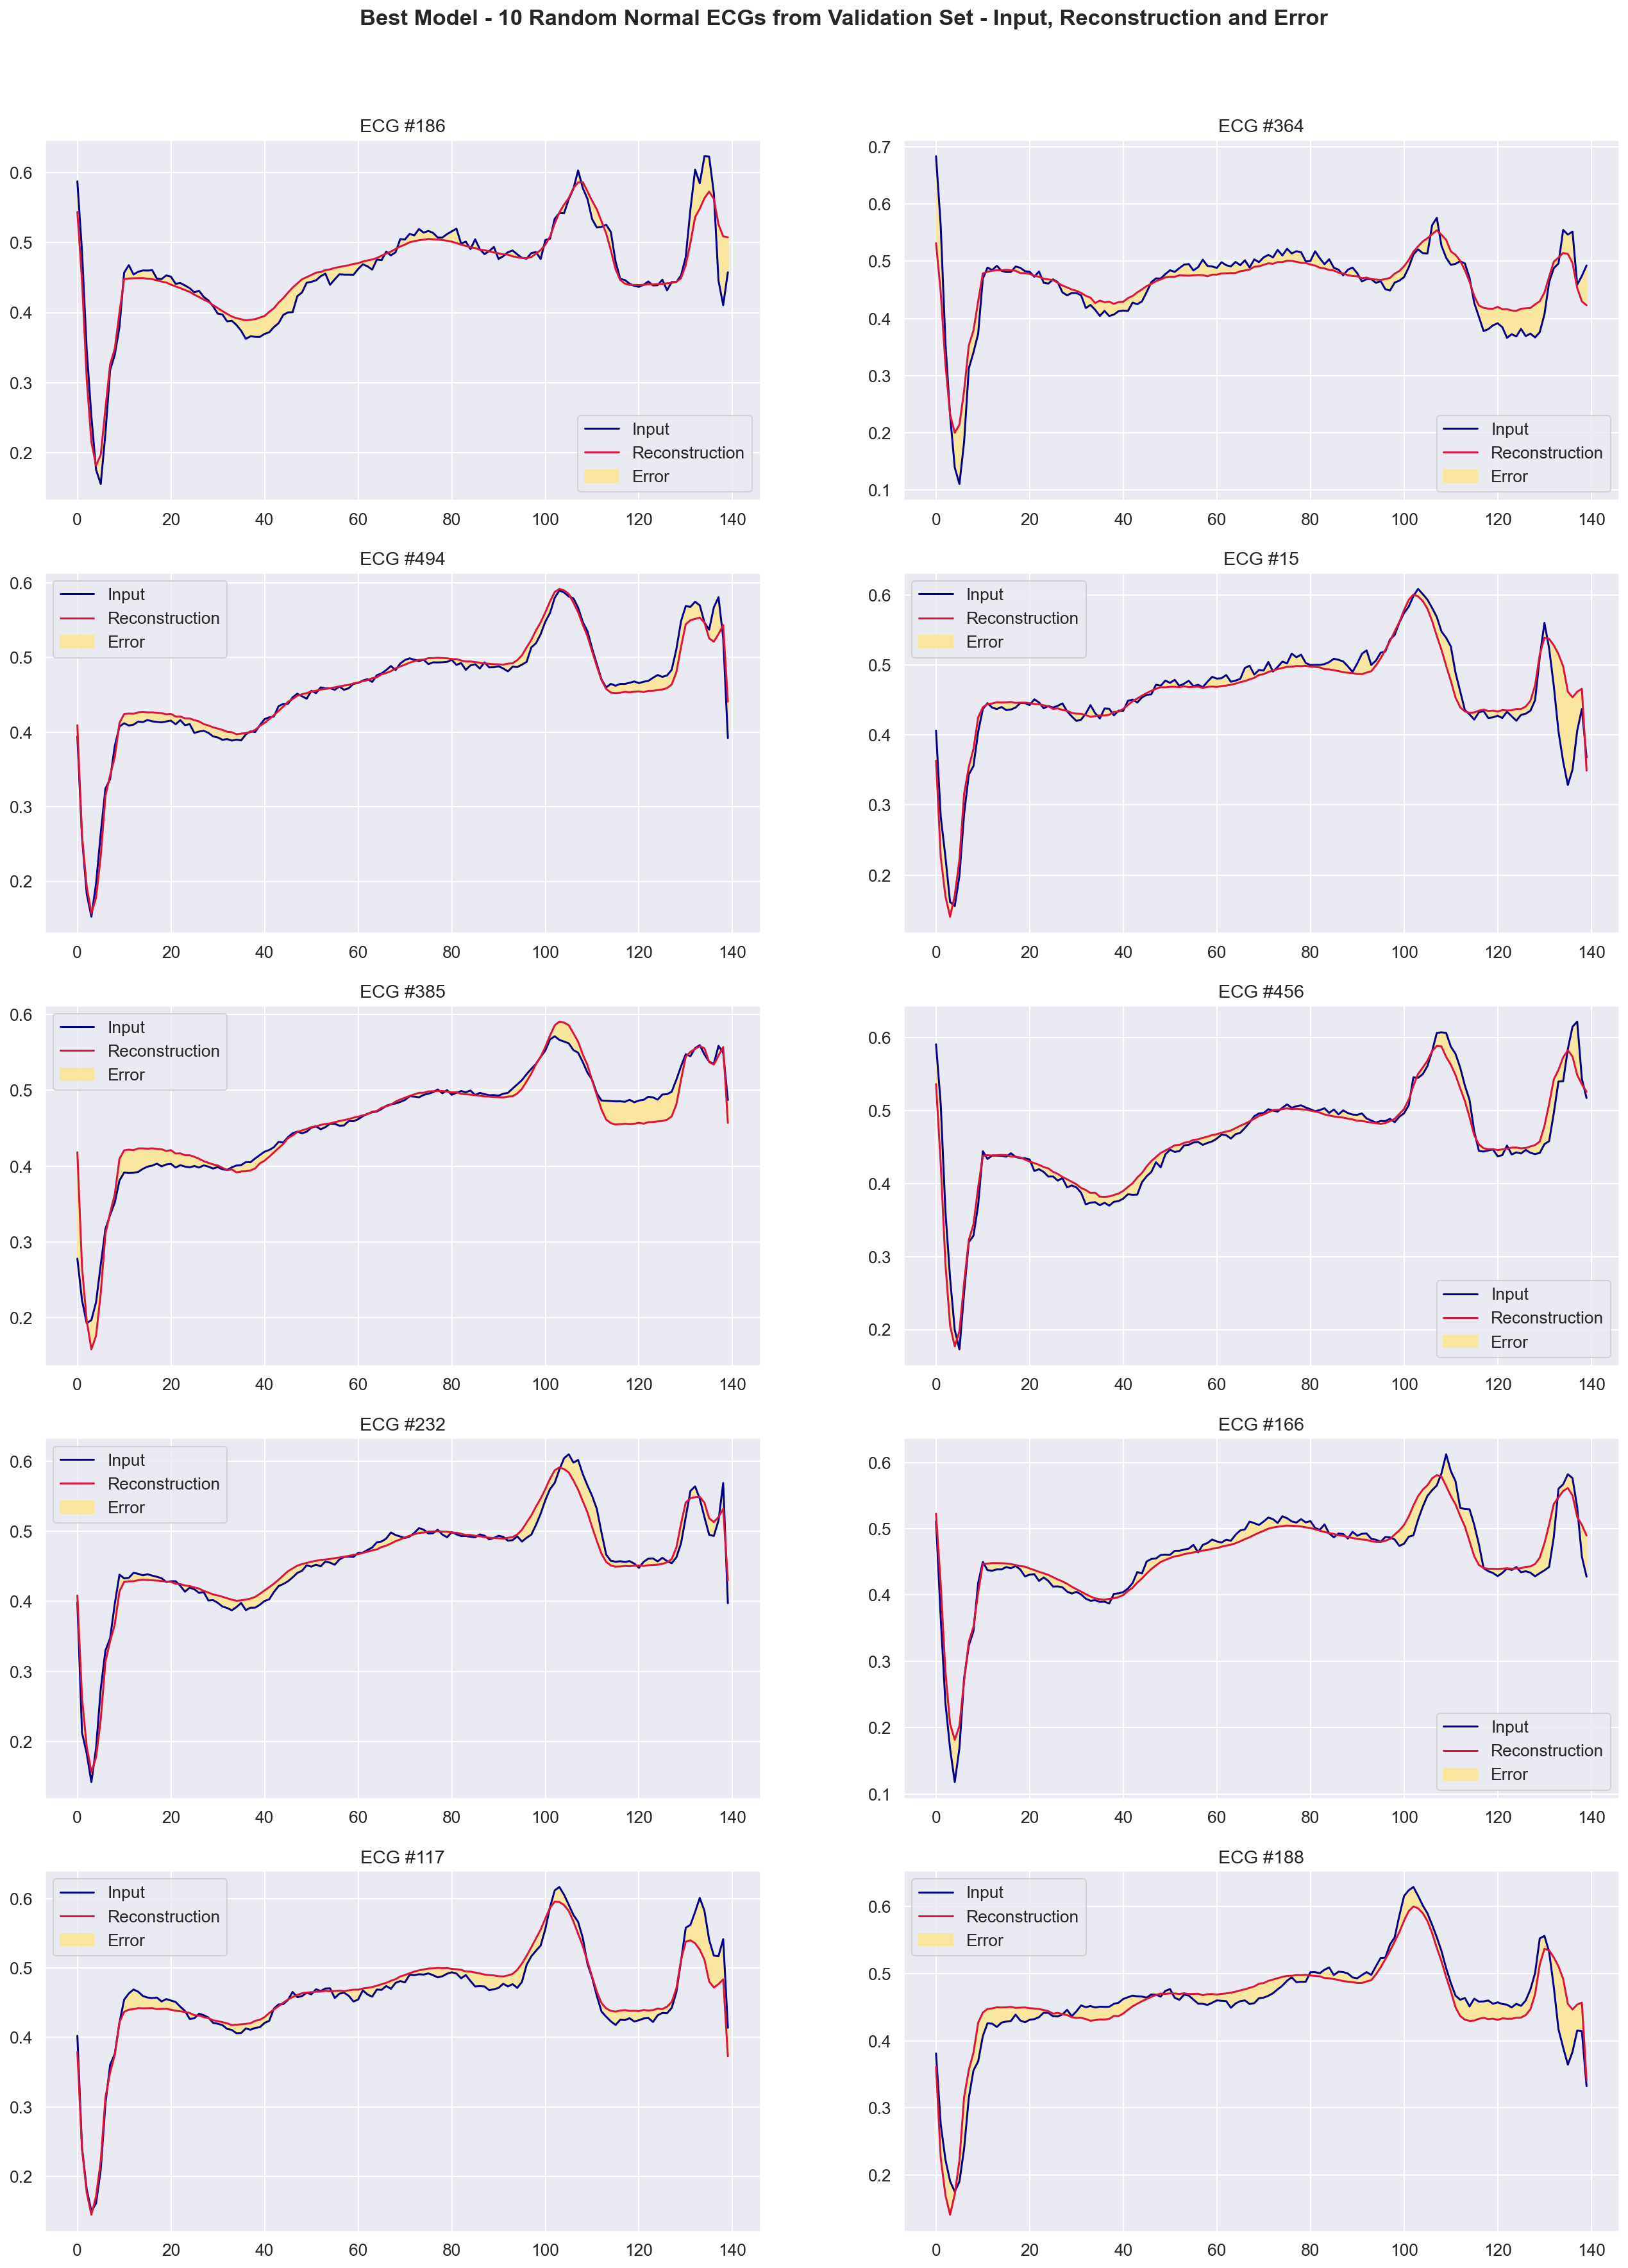

In [181]:
plot_ecg('Best Model - 10 Random Normal ECGs from Validation Set - Input, Reconstruction and Error', x_norm_test, 'images/best_model_norm_in_out.png')

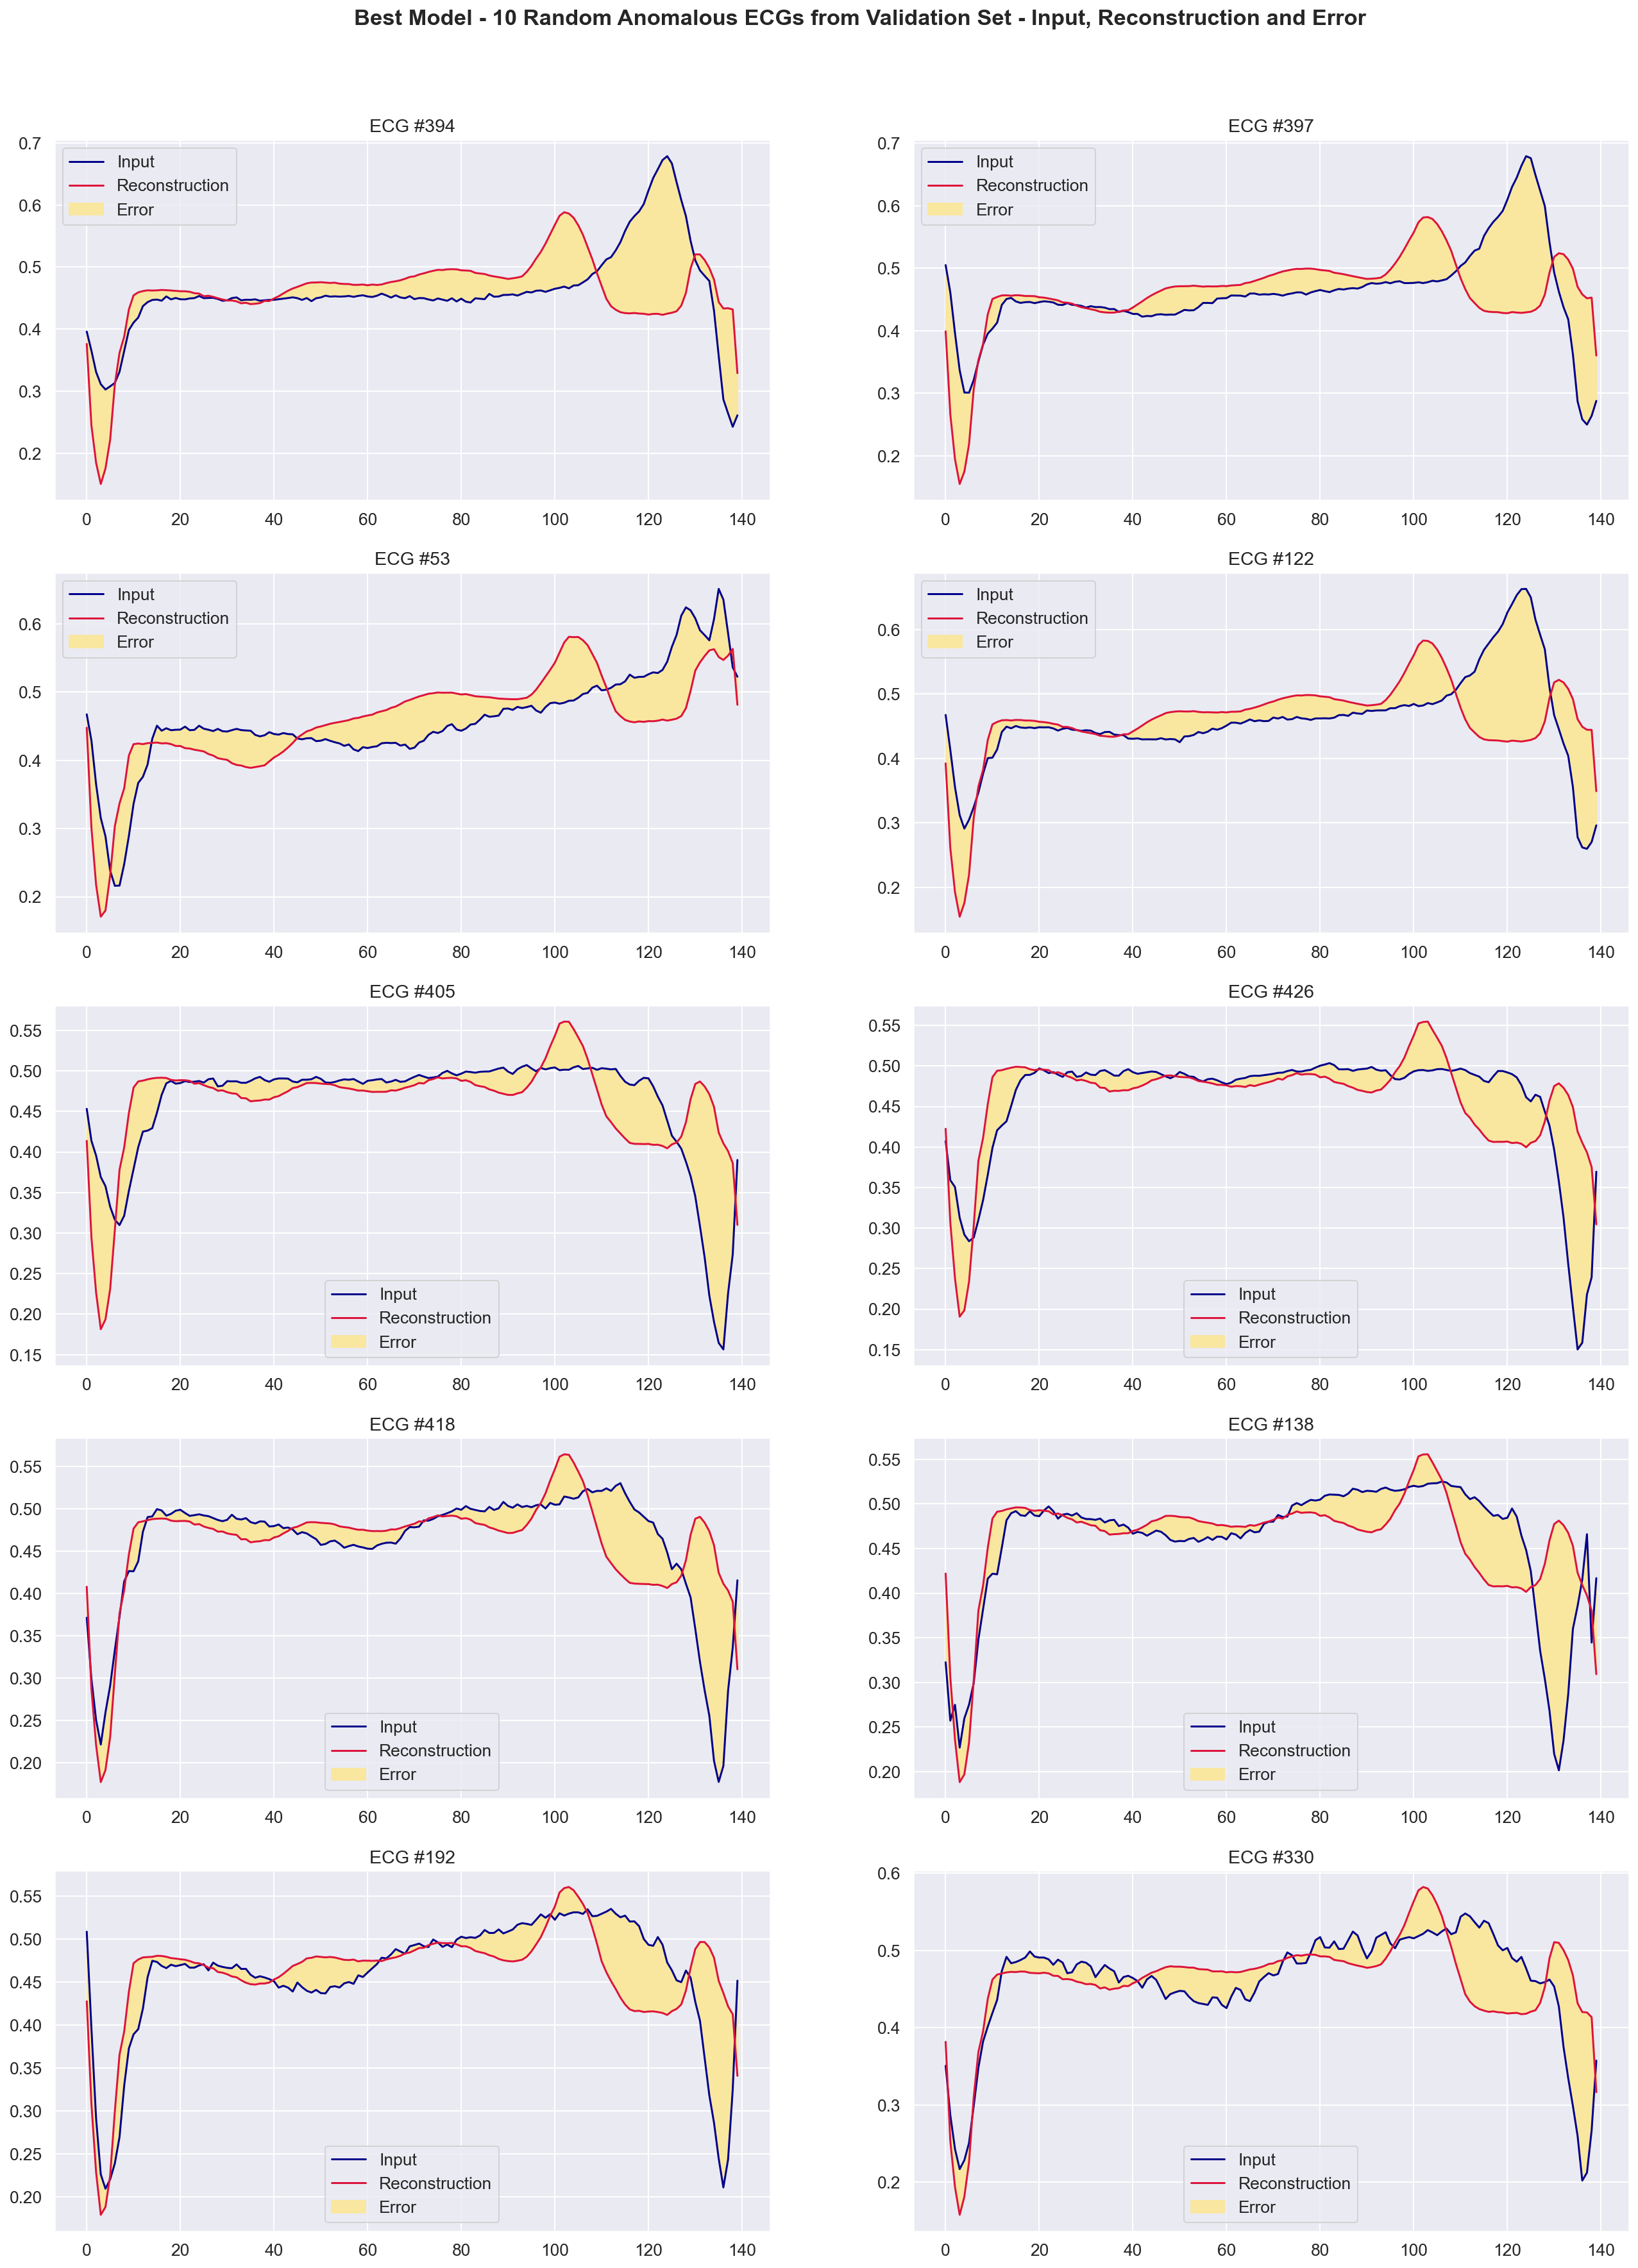

In [182]:
plot_ecg('Best Model - 10 Random Anomalous ECGs from Validation Set - Input, Reconstruction and Error', x_abnorm_test, 'images/best_model_abnorm_in_out.png')

#### Histograms illustrating the distribution of loss for the normal and anomalous ECGs

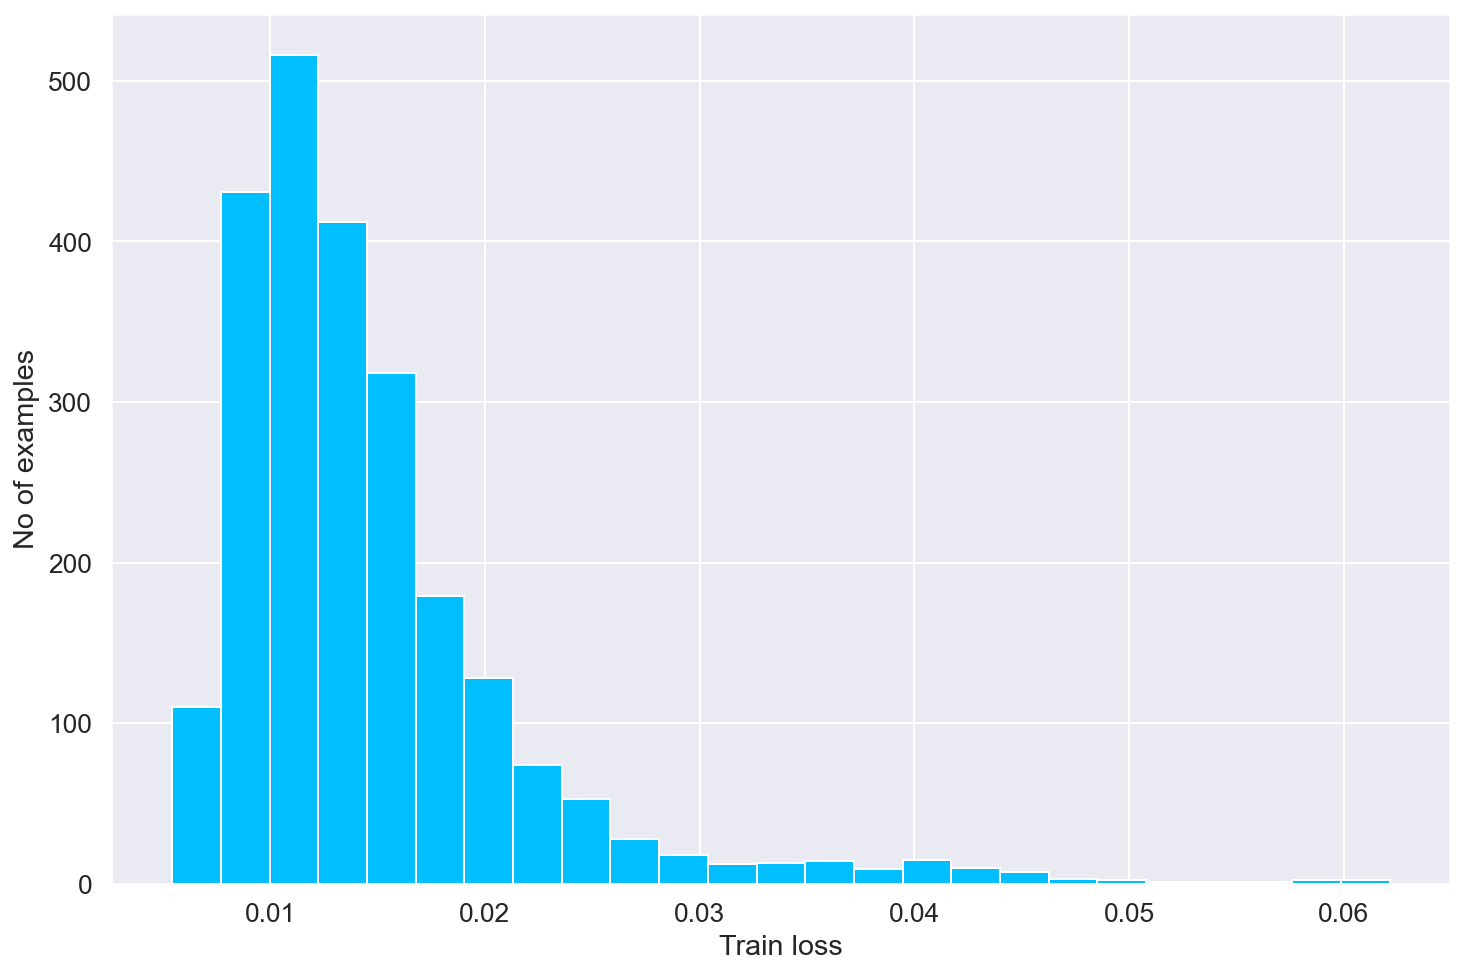

In [183]:
reconstructions = best_model.predict(x_norm_train)
train_loss = tf.keras.losses.mae(x_norm_train, reconstructions)

plt.hist(train_loss.numpy(), bins=25)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

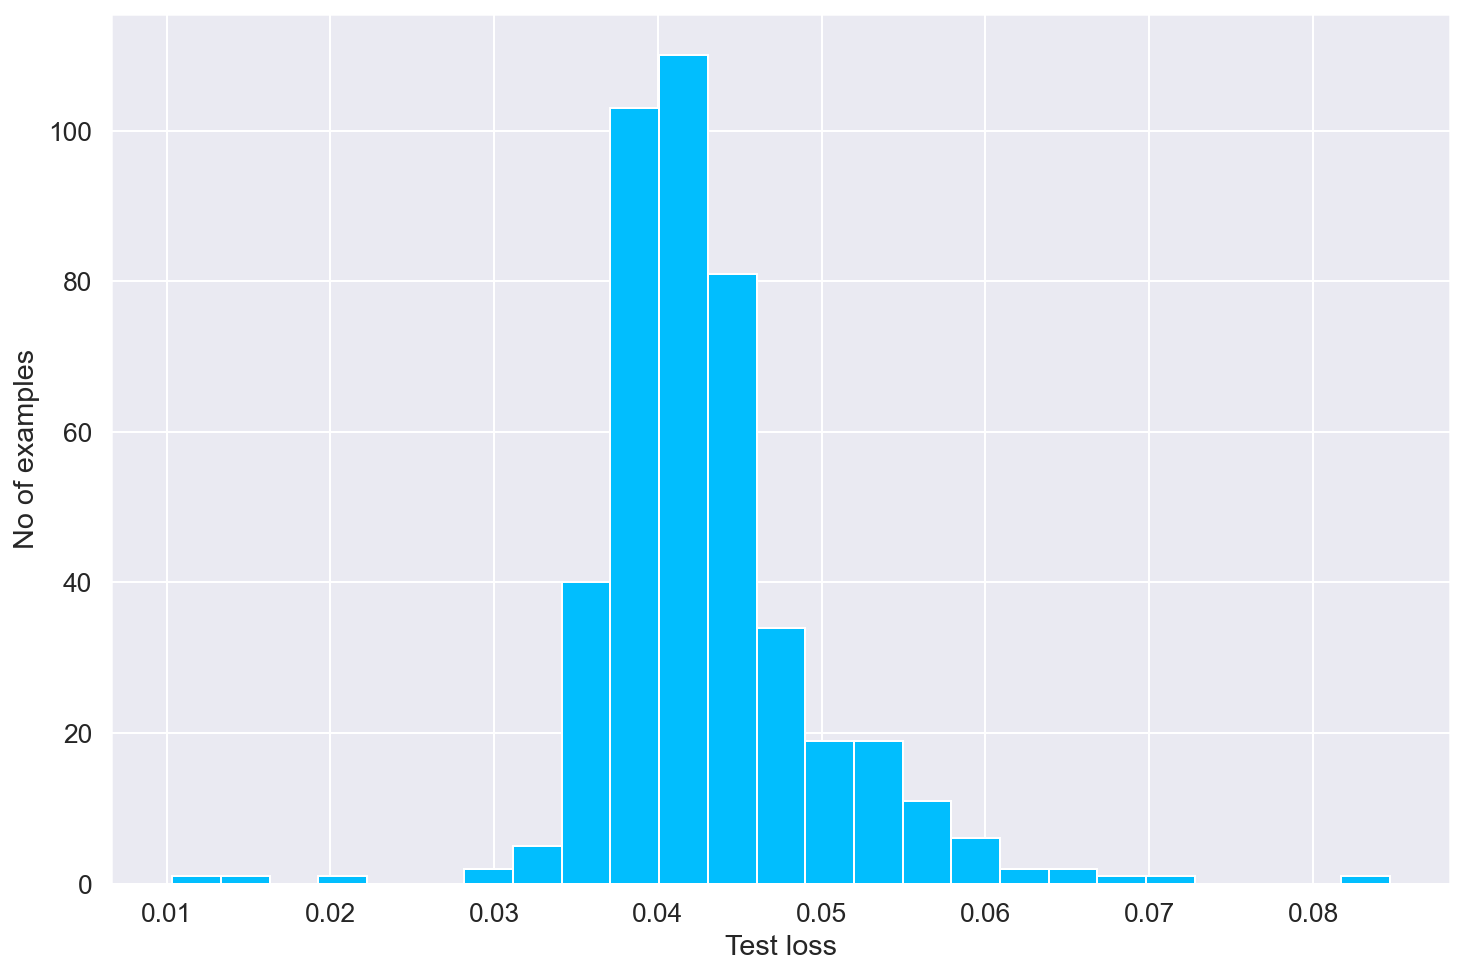

In [184]:
reconstructions = best_model.predict(x_abnorm_test)
test_loss = tf.keras.losses.mae(reconstructions, x_abnorm_test)

plt.hist(test_loss.numpy(), bins=25)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [185]:
threshold = find_threshold(best_model, x_norm_train)
preds = get_predictions(best_model, x_test, threshold)
print(f"Threshold: {threshold}")

Threshold: 0.021580299362540245


#### Calculate F1 score and Area Under the Curve (AUC)

In [186]:
from sklearn.metrics import auc

precision, recall, thresholds = precision_recall_curve(y_test, preds)
auc = auc(recall, precision)
f1 = f1_score(y_test, preds)

#### Plot AUC & Confusion Matrix

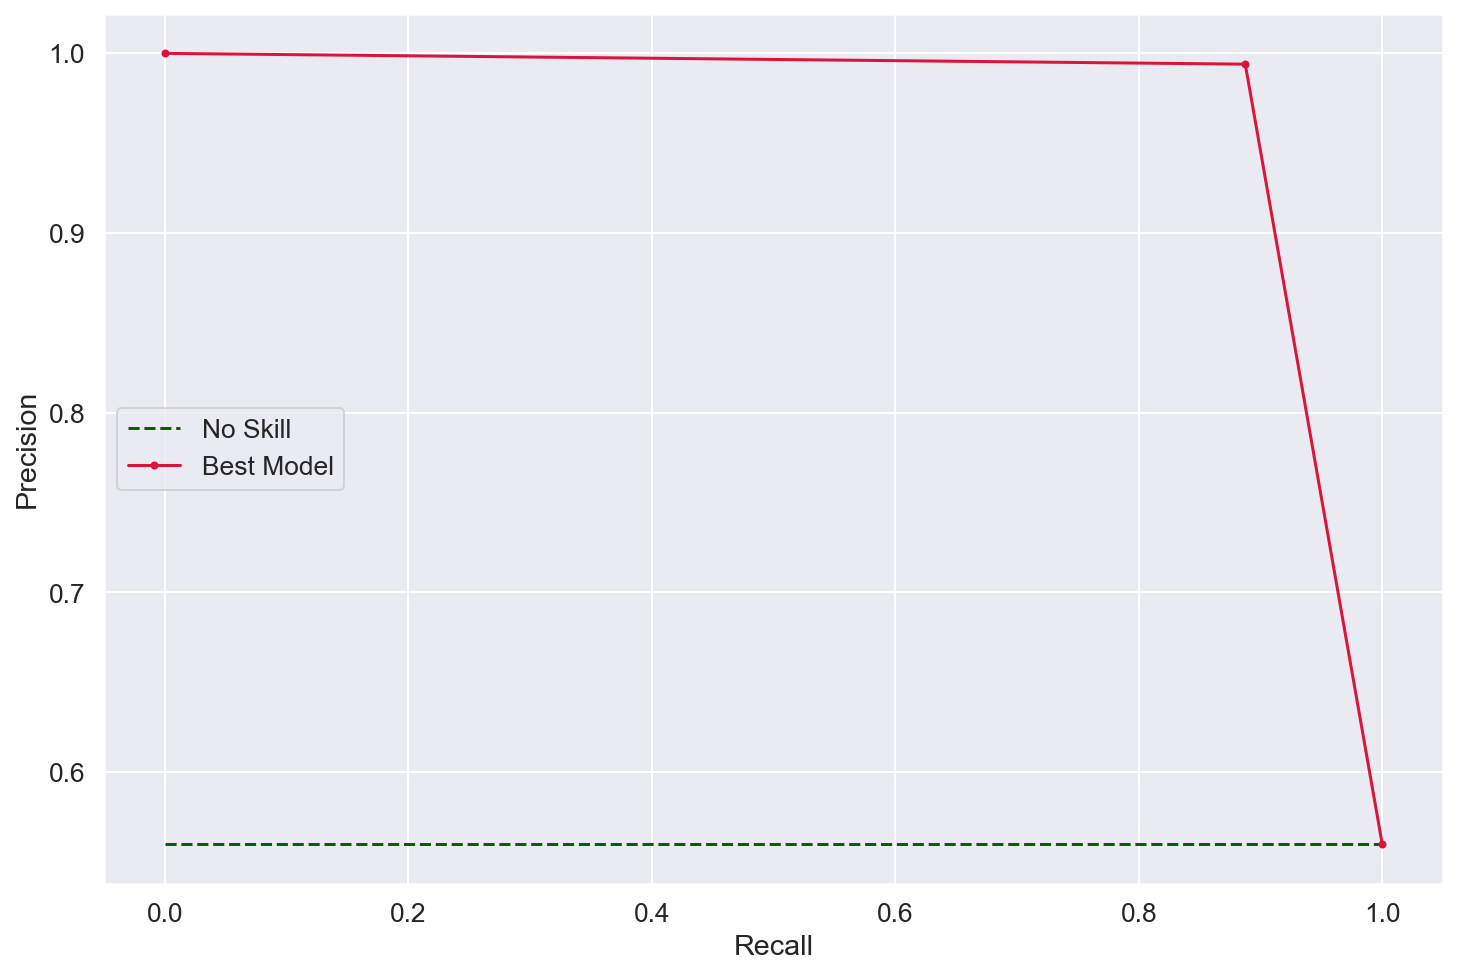

In [187]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color = 'darkgreen',label='No Skill')
plt.plot(recall, precision, marker='.', color = 'crimson', label='Best Model')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show();

### Summary of All Scores

In [188]:
print('Best Model Scores:')
print('F1 score: %.3f' % (f1))
print('AUC score: %.3f' % (auc))
print_stats(preds, y_test)

Best Model Scores:
F1 score: 0.938
AUC score: 0.972
Accuracy = 0.934
Precision = 0.994
Recall = 0.8875


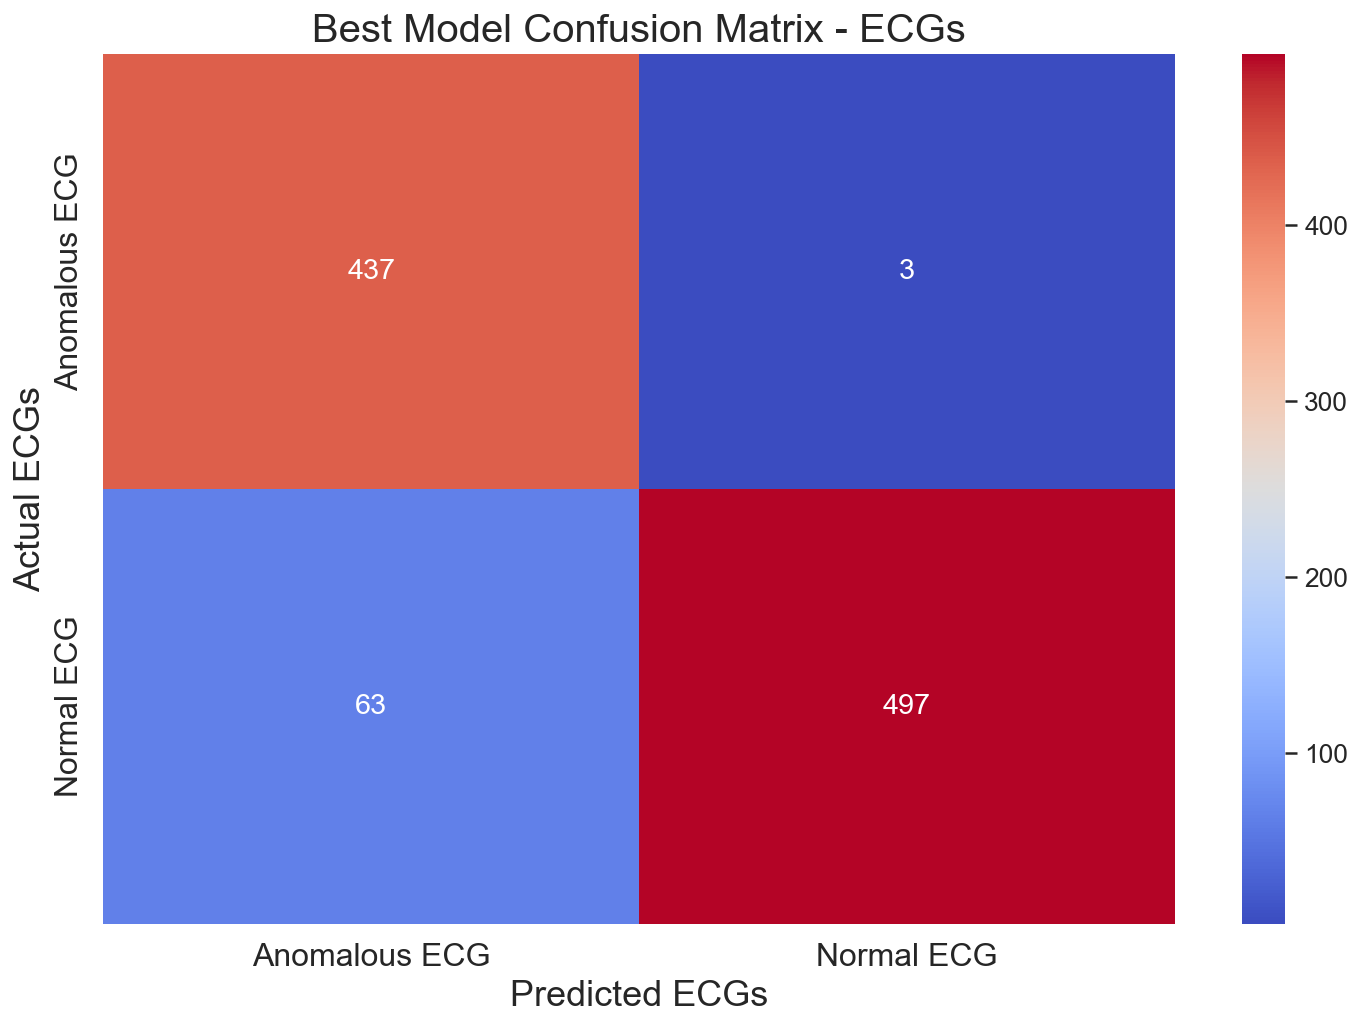

In [189]:
# Plot Confusion Matrix

cm = confusion_matrix(y_test, preds)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="coolwarm");
ax.set_title('Best Model Confusion Matrix - ECGs', fontsize=20);
ax.set_xlabel('Predicted ECGs',fontsize=18)
ax.set_ylabel('Actual ECGs',fontsize=18);
ax.xaxis.set_ticklabels(['Anomalous ECG', 'Normal ECG'],fontsize=16)
ax.yaxis.set_ticklabels(['Anomalous ECG', 'Normal ECG'],fontsize=16)

plt.savefig('images/best_model_cm.png', dpi=300, pad_inches=0.1,)
plt.show()